# Notes

Requirements:
- compute inertia of the deformed shape
- make sure mass (volume) of the deformed shape is preserved
- make sure that can change shape in a way that
    + allows the jet to be formed
    + allows the bell margin to be deflected upwards and create the starting vortex
    + let's the jellyfish deform one side in a way that induces added mass effects and net torque
- solve motion accurately

In [1]:
using Pkg
# Pkg.add(url="D:/git/ParametricBodies.jl")
Pkg.add("Tables")

    Updating registry at `C:\Users\alidtke\.julia\registries\General.toml`
   Resolving package versions...
    Updating `C:\Users\alidtke\.julia\environments\v1.8\Project.toml`
  [bd369af6] + Tables v1.10.1
  No Changes to `C:\Users\alidtke\.julia\environments\v1.8\Manifest.toml`


In [2]:
using Plots
using Images
using WaterLily
using LinearAlgebra
using StaticArrays
using Interpolations
using BasicBSpline
using ParametricBodies
using CSV
using Tables

include("D:/git/WaterLily.jl/examples/TwoD_Plots.jl")

sim_gif! (generic function with 1 method)

# Spline for GPU compatibility

In [3]:
function coxDeBoor(knots, u, k, d, count)
    if (d == 0)
        return Int(((knots[k+1] <= u) && (u < knots[k+2])) || ((u >= (1.0-1e-12)) && (k == (count-1))))
    end
    return (((u-knots[k+1]) / max(1e-12, knots[k+d+1] - knots[k+1])) * coxDeBoor(knots, u, k, (d-1), count)
        + ((knots[k+d+2]-u) / max(1e-12, knots[k+d+2] - knots[k+2])) * coxDeBoor(knots, u, (k+1), (d-1), count))
end

function bspline(cv, s; d=3)
    count = size(cv, 1)
    knots = vcat(zeros(d), range(0, count-d) / (count-d), ones(d))
    pt = zeros(size(cv, 2))
    for k in range(0, count-1)
        pt += coxDeBoor(knots, s, k, d, count) * cv[k+1, :]
    end
    return pt
end

bspline (generic function with 1 method)

In [4]:
# Test the knots
count = 5
d = 3
knots = vcat(zeros(d), range(0, count-d) / (count-d), ones(d))

println(knots)
println("expected array([0.        , 0.        , 0.        , 0.        , 0.33333333,
       0.66666667, 1.        , 1.        , 1.        , 1.        ])")

[0.0, 0.0, 0.0, 0.0, 0.5, 1.0, 1.0, 1.0, 1.0]
expected array([0.        , 0.        , 0.        , 0.        , 0.33333333,
       0.66666667, 1.        , 1.        , 1.        , 1.        ])


In [5]:
# Test the basis functions
println(coxDeBoor(knots, 0.3, 2, 3, count), " expected 0.32399999999999995")
println(coxDeBoor(knots, 0.3, 1, 2, count), " expected 0.16000000000000003")
println(coxDeBoor(knots, 0.5, 3, 3, count), " expected 0.25")
println(coxDeBoor(knots, 0.99999, 4, 1, count), " expected 0.9999999")
println(coxDeBoor(knots, 1.0, 4, 1, count), " expected 1")

0.32399999999999995 expected 0.32399999999999995
0.16000000000000003 expected 0.16000000000000003
0.25 expected 0.25
0.9999800000000001 expected 0.9999999
1.0 expected 1


In [6]:
# Test a single function value
cv = [50. 25.; 59. 12.; 50. 10.; 57. 2.; 40. 4.; 40. 14.]
s = 0.3
print(bspline(cv, s), " expected [53.82725,  9.7045]")

[53.82725000000001, 9.704500000000003] expected [53.82725,  9.7045]

┌ Warning: Keyword argument markerstrokestyle not supported with Plots.GRBackend().  Choose from: annotations, arrow, aspect_ratio, background_color, background_color_inside, background_color_outside, background_color_subplot, bar_width, bins, bottom_margin, camera, clims, color_palette, colorbar, colorbar_entry, colorbar_scale, colorbar_title, colorbar_titlefont, colorbar_titlefontcolor, colorbar_titlefontrotation, colorbar_titlefontsize, connections, contour_labels, discrete_values, fill, fill_z, fillalpha, fillcolor, fillrange, fillstyle, flip, fontfamily, fontfamily_subplot, foreground_color, foreground_color_axis, foreground_color_border, foreground_color_grid, foreground_color_subplot, foreground_color_text, framestyle, grid, gridalpha, gridlinewidth, gridstyle, group, guide, guidefontcolor, guidefontfamily, guidefonthalign, guidefontrotation, guidefontsize, guidefontvalign, html_output_format, inset_subplots, label, layout, left_margin, legend_background_color, legend_column, le

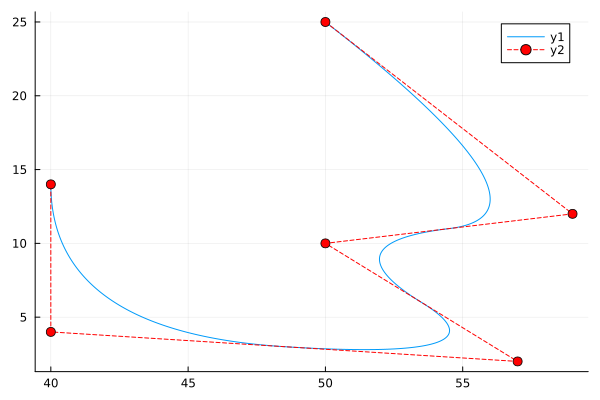

In [7]:
# Test evaluation of a curve
s = range(0, 1, 1001)
p = transpose(hcat([bspline(cv, u; d=2) for u in s]...))
plot(p[:, 1], p[:, 2])
plot!(cv[:, 1], cv[:, 2], c=:red, ls=:dash, markers=:dot, markersize=5)

# Figuring out medusa shape and kinematics

## Bell shape

`TODO would be better to make this parametric w.r.t. the length along the shape instead of theta!`

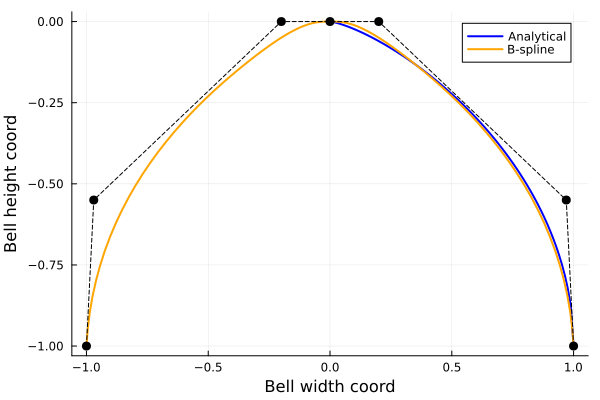

In [8]:
# Create a function that approximates the shape.
bellShapeX = s -> (1-cos(clamp(s, 0, 1)*pi/2))^.75
bellShapeY = s -> (sin(pi/2 - clamp(s, 0, 1)*(pi/2)))^0.5 - 1

# Redo with a spline.
# T = np.hstack([[0]*M, np.arange(pts.shape[0]-M+1), [pts.shape[0]-M]*M])
# p = 3
# kVec = Float64[0, 0, 0, 0, 1, 2, 2, 2, 2]
# controlPoints = [[0, 0], [0.5, 0.0], [1, 0], [1, -0.5], [1, -1]]
# p = 2
# kVec = Float64[0, 0, 0, 1, 2, 2, 2]
# controlPoints = [[0, 0], [0.2, 0], [0.97, -0.55], [1, -1]]
p = 3
kVec = Float64[0, 0, 0, 0, 1, 2, 3, 4, 4, 4, 4]
controlPoints = [[-1, -1], [-0.97, -0.55], [-0.2, 0], [0, 0], [0.2, 0], [0.97, -0.55], [1, -1]]

kVec ./= maximum(kVec)
k = KnotVector(kVec)
P = BSplineSpace{p}(k)
bell_spline = BSplineManifold(controlPoints, P)

# Evaluate for plotting.
xy = bell_spline.(0:0.01:1)
x = [v[1] for v in xy]
y = [v[2] for v in xy]
xy_spline = hcat(x, y)'
xc = [v[1] for v in controlPoints]
yc = [v[2] for v in controlPoints]
xy_cp = hcat(xc, yc)'

# Create the shape (non-dimensional) with origin at the bell top
s = 0:0.01:1
x_bell = bellShapeX.(s)
y_bell = bellShapeY.(s)
plot(x_bell, y_bell, lw=2, c=:blue, label="Analytical",
    xlabel="Bell width coord", ylabel="Bell height coord")
plot!(xy_spline[1, :], xy_spline[2, :], c=:orange, lw=2, label="B-spline")
plot!(xy_cp[1, :], xy_cp[2, :], c=:black, ls=:dash, marker=:circle, ms=5, label=nothing)

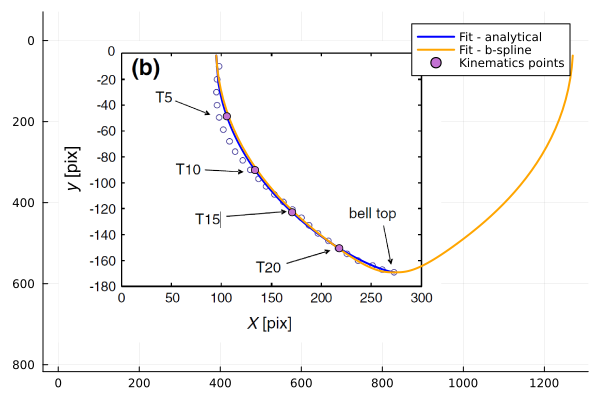

In [9]:
# Load measurement data from DOI 10.1007/s10750-008-9589-4 displaying outer (exumbrellar) surface
# of the bell of scyphomedusa (Aurelia sp.).
im = load("./dataset_01_medusae/Bajacaret2009_fig4_bellShape.PNG")
plot(im)

# Compare to the proposed shape - scale to pixels and set at the correct orientation.
dims = [440, 535]
origin = [830, 572]

xs = -x_bell .* dims[1] .+ origin[1]
ys = y_bell .* dims[2] .+ origin[2]
plot!(xs, ys, lw=2, c=:blue, label="Fit - analytical")
plot!(-xy_spline[1, :] .* dims[1] .+ origin[1], xy_spline[2, :] .* dims[2] .+ origin[2],
    lw=2, c=:orange, label="Fit - b-spline")

# Create location of the monitoring points used to validate the motion kinematics.
s_motion = [0.42, 0.65, 0.82, 0.95]
# s_motion = [0.95]
x_motion = bellShapeX.(s_motion)
y_motion = bellShapeY.(s_motion)
scatter!(-x_motion.*dims[1].+origin[1], y_motion.*dims[2].+origin[2], label="Kinematics points")

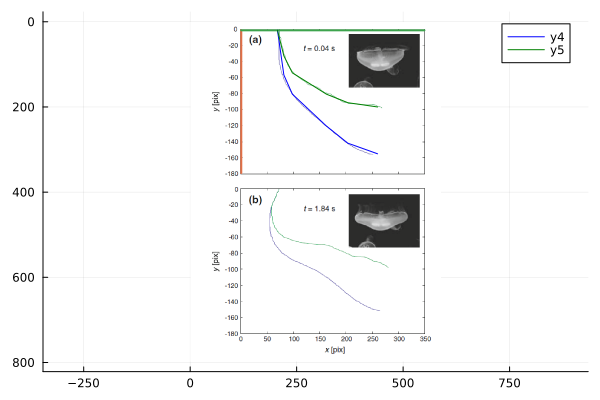

In [10]:
# Load measurement data from DOI 10.1007/s10750-008-9589-4 displaying outer (exumbrellar)
# and inner (subumbrellar) surface of the bell of scyphomedusa (Aurelia sp.).
im = load("./dataset_01_medusae/Bajacaret2009_fig8_bellThickness.PNG")
plot(im)

x0 = [120, 20]
scale_x = 430
scale_y = 335

plot!([x0[1], x0[1]], [x0[2], x0[2]+scale_y], lw=2, label="")
plot!([x0[1], x0[1]+scale_x], [x0[2], x0[2]], lw=2, label="")

xu = [85, 100, 120, 200, 250, 320]
yu = [0, 105, 150, 225, 265, 290]
plot!(xu.+x0[1], yu.+x0[2], c=:blue)

xl = [85, 100, 120, 200, 250, 320]
yl = [0, 60, 100, 150, 170, 180]
plot!(xl.+x0[1], yl.+x0[2], c=:green)

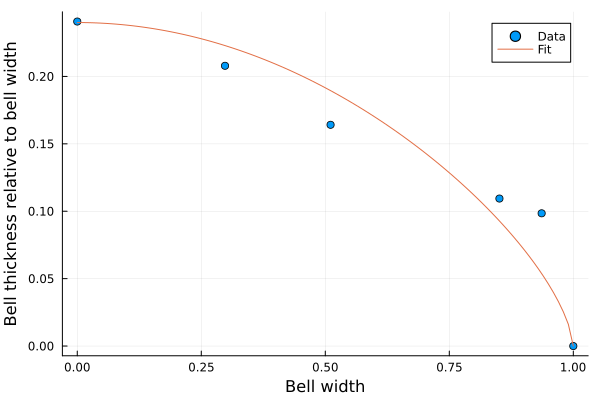

In [11]:
# Thickness expressed as relative to half-width of the bell
dim = (xl[end] - xl[1]) * 350
thickness = (yu - yl) .* 180 ./ dim

scatter(1 .- (xl.-xl[1]) .* 350 ./ dim, thickness, label="Data", xlabel="Bell width",
    ylabel="Bell thickness relative to bell width")

xfit = 0:0.01:1
yfit = 0.24 .* (cos.(xfit*pi/2)).^.65
plot!(xfit, yfit, label="Fit")

## Bell motion

`TODO the research by Bajacaret et al. hadn't recognised the up-flip in the bell shape reported by Costello et al. This is very important from a hydrodynamic standpoint. Need to add a second deformation mode for it.`

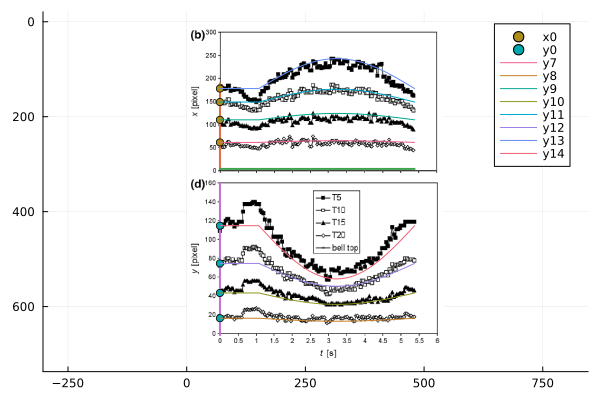

In [12]:
# Apply motion.
# Assumption: bell is relaxad for part of the duration of the complete cycle
# (https://doi.org/10.1146/annurev-marine-031120-091442) and half a sine wave otherwise.
amplitudes = [0.02, 0.075, 0.15, 0.35]
t = 0:0.01:1
f_relax = 0.2
deformed = []
for i in range(1, length(amplitudes))
    x = []
    y = []
    for tt in t
        if tt > f_relax
            push!(x, x_motion[i] + amplitudes[i]*sin((tt-f_relax)/(1-f_relax)*pi))
            push!(y, y_motion[i] + amplitudes[i]*sin((tt-f_relax)/(1-f_relax)*pi))
        else
            push!(x, x_motion[i])
            push!(y, y_motion[i])
        end
    end
    push!(deformed, [x, y])
end

# Load measurement data from DOI 10.1007/s10750-008-9589-4.
im = load("./dataset_01_medusae/Bajacaret2009_fig6_bellMotion_cropped.PNG")
plot(im)

# Figure out plot coordinates.
x0_x = [70, 310]
scale_x = -180#-290

x0_y = [70, 660]
scale_y = -320

scale_t = 410

plot!([x0_x[1], x0_x[1]], [x0_x[2], x0_x[2]+scale_x], lw=2, label="")
plot!([x0_x[1], x0_x[1]+scale_t], [x0_x[2], x0_x[2]], lw=2, label="")
plot!([x0_y[1], x0_y[1]], [x0_y[2], x0_y[2]+scale_y], lw=2, label="")

# Plot the position of the points in the baseline underformed configuration
scatter!(zeros(length(x_motion)).+x0_x[1], x_motion.*scale_x .+ x0_x[2], label="x0")
scatter!(zeros(length(y_motion)).+x0_y[1], -y_motion.*scale_y .+ x0_y[2], label="y0")

# TODO how to plot inside a bloody loop?
plot!(t.*scale_t.+x0_x[1], deformed[1][1].*scale_x .+ x0_x[2])
plot!(t.*scale_t.+x0_y[1], -deformed[1][2].*scale_y .+ x0_y[2])

plot!(t.*scale_t.+x0_x[1], deformed[2][1].*scale_x .+ x0_x[2])
plot!(t.*scale_t.+x0_y[1], -deformed[2][2].*scale_y .+ x0_y[2])

plot!(t.*scale_t.+x0_x[1], deformed[3][1].*scale_x .+ x0_x[2])
plot!(t.*scale_t.+x0_y[1], -deformed[3][2].*scale_y .+ x0_y[2])

plot!(t.*scale_t.+x0_x[1], deformed[4][1].*scale_x .+ x0_x[2])
plot!(t.*scale_t.+x0_y[1], -deformed[4][2].*scale_y .+ x0_y[2])


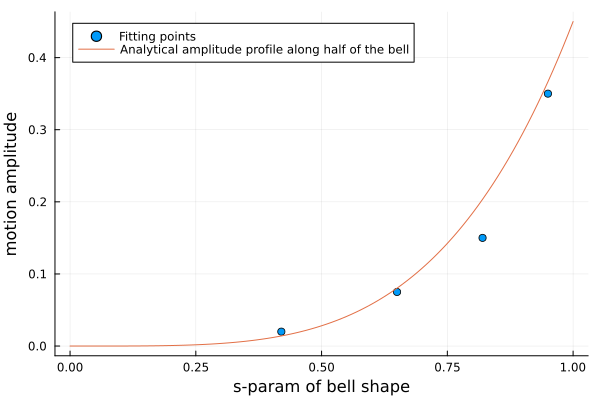

In [13]:
scatter(s_motion, amplitudes, label="Fitting points",
    xlabel="s-param of bell shape", ylabel="motion amplitude")

amp_fit = 0.45.*s.^4
plot!(s, amp_fit, label="Analytical amplitude profile along half of the bell")

In [14]:
function deformedBell(s, t; A_max=0.45, f_relax=0.2)
    x0 = bellShapeX.(s)
    y0 = bellShapeY.(s)
    A = A_max.*s.^4
    x = []
    y = []
    for i in range(1, length(x0))
        if t > f_relax
            push!(x, x0[i] + A[i]*sin((t-f_relax)/(1-f_relax)*pi))
            push!(y, y0[i] + A[i]*sin((t-f_relax)/(1-f_relax)*pi))
        else
            push!(x, x0[i])
            push!(y, y0[i])
        end
    end
    return x, y
end

deformedBell (generic function with 1 method)

In [15]:
function bell_shape_func(t)
    p = 3
    kVec = Float64[0, 0, 0, 0, 1, 2, 3, 4, 4, 4, 4]
    controlPoints = [[-1, -1], [-0.97, -0.55], [-0.2, 0], [0, 0], [0.2, 0], [0.97, -0.55], [1, -1]]
    
    function rotateSegment(iJoint, iMove, theta)
        for j in iMove
            pt = controlPoints[j] - controlPoints[iJoint]
            xr = pt[1]*cos(theta) - pt[2]*sin(theta)
            yr = pt[2]*cos(theta) + pt[1]*sin(theta)
            controlPoints[j] = [xr, yr] + controlPoints[iJoint]
        end
    end

    # Rotate the control points acoording to the motion.
    # half sine wave so from 0 to 1 and back to 0
    rotateSegment(5, 6:1:length(controlPoints), 20.0/180.0*pi * sin(pi*t))
    rotateSegment(6, 6:1:length(controlPoints), 25.0/180.0*pi * sin(pi*t))

    # Define the rest of the spline elements.
    kVec ./= maximum(kVec)
    k = KnotVector(kVec)
    P = BSplineSpace{p}(k)
    spline = BSplineManifold(controlPoints, P)
    
    # Evaluate for plotting.
    xy = spline.(0:0.05:1)
    x = [v[1] for v in xy]
    y = [v[2] for v in xy]
    xy_spline = hcat(x, y)'
    xc = [v[1] for v in controlPoints]
    yc = [v[2] for v in controlPoints]
    xy_cp = hcat(xc, yc)'
    
    return xy_spline
end

bell_shape_func (generic function with 1 method)

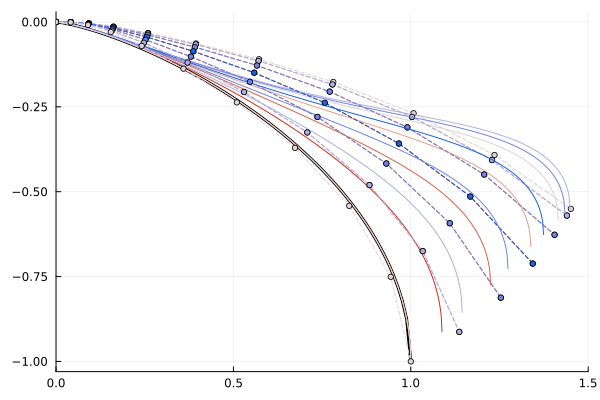

In [31]:
# Plot the deformed shape at a few points during a cycle.
begin
	plot(x_bell, y_bell, lw=3, c=:black)
    
	colors = palette(:cyclic_wrwbw_40_90_c42_n256)
	for t in 1/12:1/12:1
        # Plot using the original analytical definition.
        xd, yd = deformedBell(0:0.001:1, t; f_relax=0.2)
        plot!(xd, yd, color=colors[floor(Int,t*256)])
        
        CSV.write("dataset_01_medusae/shapeFromAnalytical_$t.csv",  Tables.table(hcat(xd, yd)), writeheader=false)
        
        # Approximate using a spline.
        xy_sp = bell_shape_func(t)
        plot!(xy_sp[1, :], xy_sp[2, :], color=colors[floor(Int,t*256)],
            ls=:dash, marker=:circle, ms=3, label=nothing)
	end
    
	plot!(xlim=(0, 1.5), legend=false)
end

In [17]:
# Load measurement data from Costello et al.
im = load("./dataset_01_medusae/Costello2020_fig9_stoppingVortex.PNG")
plot(im)

# TODO under construction


## Defin a signed distance function for the deformed bell shape

`TODO under construction`

In [18]:

# begin
# 	function jellyfish(; U=1, L=2^6, A=0.45, St=0.3, Re=1e2)
#         # TODO this should vary along the length of the bell
#         thk = 0.1
        
# 		# fraction along fish length
# 		s(x) = clamp(x[1]/L,0,1)
		
# 		# geometry: thickened line SDF
# 		sdf(x,t) = √sum(abs2, x-L*SVector(0., 0.)) - L*thk

# 		# # motion
# 		# U=1
# 		# ω = 2π*St*U/(2A*L)
# 		# function map(x,t)
# 		# 	xc = x.-L # shift origin
# 		# 	return xc-SVector(0.,A*L*amp(s(xc))*sin(k*s(xc)-ω*t))
# 		# end
		
# 		# make the fish simulation
# 		return Simulation((4L+2, 2L+2), [U, 0.], L;
#             ν=U*L/Re, body=AutoBody(sdf))#, map))
# 	end
	
# 	# Create the swimming jellyfish
# 	L, A, St = 3*2^5, 0.45, 0.3
# 	swimmer = jellyfish(; L, A, St);
# end

# # Save a time span for one swimming cycle
# period = 2*A/St
# cycle = range(0, 23/24*period, length=24)

# @gif for t ∈ cycle
# 	measure!(swimmer, t*swimmer.L/swimmer.U);
# 	contour(swimmer.flow.μ₀[:,:,1]', aspect_ratio=:equal, legend=false)
# end

In [19]:


# fit = y-> scale(interpolate(y, BSpline(Quadratic(Line(OnGrid())))), range(0,1,length=length(y)))

# begin
#     # Data from the shark example
# 	# width = [0.02,0.07,0.06,0.048,0.03,0.019,0.01]
# 	# thk = fit(width)
#     # Fit to measurement data of a real jellyfish. Divided by two since this is taken as +/- form the midline.
#     thk(s) = (0.24/2.0) .* (cos.(s*pi/2)).^.65
# end

# begin
#     # Data from the shark example.
# 	#envelope = [0.2,0.21,0.23,0.4,0.88,1.0]
# 	#amp = fit(envelope)
#     amp(s) =  0.45.*s.^4
# end

# begin
# 	function fish(thk,amp,k=5.3;L=2^6,A=0.1,St=0.3,Re=1e4)
# 		# fraction along fish length
# 		s(x) = clamp(x[1]/L, -1, 1)
		
# 		# fish geometry: thickened line SDF
# 		# sdf(x,t) = √sum(abs2, x-L*SVector(s(x), 0.)) - L*thk(s(x))
        
#         function sdf(x, t)
#             if abs(x[2]/L) <= cos(x[1]/L)
#                 sv = ((x[1] / L + π/2) / π - 0.5) / 0.5
#                 return abs(x[2]/L - cos(x[1]/L)) - L*thk(sv)
#             else
#                 return sqrt((x[1]/L - π/2)^2 + (x[2]/L)^2) - L*thk(1)
#             end
#         end

# 		# fish motion: travelling wave
# 		U=1
# 		ω = 2π*St*U/(2A*L)
#         T = 2*pi/ω
# 		function map(x,t)
# 			xc = x .- [2*L, 1*L] # shift origin
#             f_relax = 0.2
# 			return xc - SVector(
#                 # A*L*amp(s(xc)) * sin(k*s(xc)-ω*t),
#                 0,
#                 L*A*amp(s(xc)) * cos(k*abs(s(xc))-ω*t)
#             )
# 		end
# 		# bellShapeX = s -> (1-cos(clamp(s, 0, 1)*pi/2))^.75
# 		# bellShapeY = s -> (sin(pi/2 - clamp(s, 0, 1)*(pi/2)))^0.5 - 1
        
# 		# make the fish simulation
# 		return Simulation((4L+2, 2L+2), [U, 0.], L;
#             ν=U*L/Re, body=AutoBody(sdf, map))
# 	end
	
# 	# Create the swimming shark
# 	L,A,St = 3*2^5,0.1,0.3
#     println(L)
# 	swimmer = fish(thk, amp; L, A, St);
	
# 	# Save a time span for one swimming cycle
# 	period = 2A/St
# 	cycle = range(0,23/24*period,length=24)
# end

# @gif for t ∈ cycle
# 	measure!(swimmer,t*swimmer.L/swimmer.U);
# 	contour(swimmer.flow.μ₀[:,:,1]',
# 		aspect_ratio=:equal,legend=false)#,border=:none)
# end

# Simple static shape using a b-spline

[ Info: Saved animation to C:\Users\alidtke\Documents\tmp.gif


Plots.AnimatedGif("C:\\Users\\alidtke\\Documents\\tmp.gif")
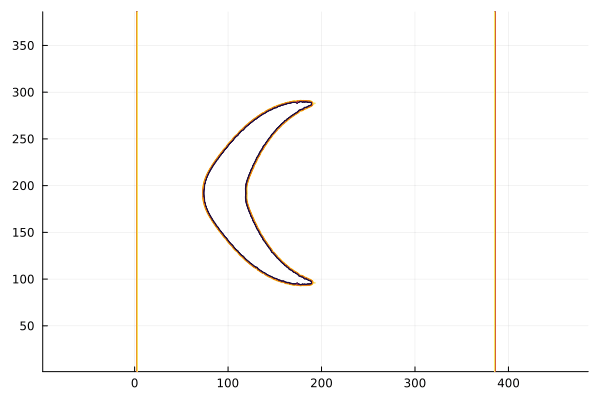

In [20]:
# p = 3
# kVec = Float64[0, 0, 0, 0, 1, 2, 3, 4, 4, 4, 4]
# controlPoints = [[-1, -1], [-0.97, -0.55], [-0.2, 0], [0, 0], [0.2, 0], [0.97, -0.55], [1, -1]]
# kVec ./= maximum(kVec)
# k = KnotVector(kVec)
# P = BSplineSpace{p}(k)
# bell_spline = BSplineManifold([[-v[2], v[1]] for v in controlPoints], P)


begin
	function fish(L, T, Re)#thk, amp, k=5.3; A=0.1, St=0.3, Re=1e4)
        
        U = 1
        
        function spline_sdf(x, t)

            # Thickness function - symmetric about s=0.5
            thickness = s -> 0.24 .* (cos.(abs(s-0.5)/0.5*pi/2)).^.65

            # Baseline (undeformed) bell shape
            p = 3
            kVec = Float64[0, 0, 0, 0, 1, 2, 3, 4, 4, 4, 4]
            controlPoints = [[-1, -1], [-0.97, -0.55], [-0.2, 0], [0, 0], [0.2, 0], [0.97, -0.55], [1, -1]]

            # Function for rotating points around a specific joint point.
            function rotateSegment(iJoint, iMove, theta)
                for j in iMove
                    pt = controlPoints[j] - controlPoints[iJoint]
                    xr = pt[1]*cos(theta) - pt[2]*sin(theta)
                    yr = pt[2]*cos(theta) + pt[1]*sin(theta)
                    controlPoints[j] = [xr, yr] + controlPoints[iJoint]
                end
            end

            # Rotate the control points acoording to the motion.
            # half sine wave so from 0 to 1 and back to 0
            rotateSegment(5, 6:1:length(controlPoints), 20.0/180.0*pi * sin(pi*t/T))
            rotateSegment(6, 6:1:length(controlPoints), 25.0/180.0*pi * sin(pi*t/T))
            rotateSegment(3, 1:2, -20.0/180.0*pi * sin(pi*t/T))
            rotateSegment(2, 1:1, -25.0/180.0*pi * sin(pi*t/T))

            # Define and instantiate the spline object.
            kVec ./= maximum(kVec)
            k = KnotVector(kVec)
            P = BSplineSpace{p}(k)
            bell_spline = BSplineManifold([[-v[2], v[1]] for v in controlPoints], P)

            # Define curve function returning a 2D point based on the parameter `s`
            curve_function = s -> bell_spline.(s)[1:2]

            # Initialize the minimum distance and closest point
            min_distance = Inf

            # Will look for relative change in s for the nearest point (according to SDF)
            # to be below a theshold level.
            s_old = 10.
            s_min = 0.5

            # Search for minimum SDF value using a reduced-trust region approach.
            # This is adopted to allow for complex spline shapes with multiple local
            # minima, but is expensive. Maybe some simple optimiser like a Golden rule
            # search of Newton-Raphson could work better for simple shapes?
            iter = 1
            while abs(s_old-s_min) > 0.01
                if iter == 1
                    s_old = 10.
                else
                    s_old = s_min
                end

                # NOTE: for jagged sdf contours, push the no. points up.
                s = range(clamp(s_min-0.5/iter, 0, 1), clamp(s_min+0.5/iter, 0, 1), 21)

                # Iterate over target points and find the closest point
                # TODO is there an argmin in Julia? This could become a one-liner
                for i in 1:1:length(s)
                    distance = norm(x - (curve_function(s[i])*L + [L, 2*L])) - thickness(s[i])*L
                    if distance < min_distance
                        min_distance = distance
                        s_min = s[i]
                    end
                end

                # Safety.
                iter += 1
                if iter > 10
                    break
                end
            end

            return min_distance
        end

		# make the fish simulation
		return Simulation((4L+2, 4L+2), [U, 0.], L;
            ν=U*L/Re, body=AutoBody(spline_sdf))#, map))
	end
    
    # U=1
    T = 0.2
    Re = 10.0
    L = 3*2^5
	
# Create the swimming shark
# L_,A,St = 3*2^5,0.1,0.3
# println(L)
	swimmer = fish(L, T, Re);
#0.1, 0.; A, St);
	
	# Save a time span for one swimming cycle
# period = 2A/St
	cycle = range(0, 23/24*T, length=24)
end

@gif for t ∈ cycle
    
    # println(t, " ", t*swimmer.L/swimmer.U, " ", t/T)

	measure!(swimmer, t);#*swimmer.L/swimmer.U);
	contour(swimmer.flow.μ₀[:,:,1]', aspect_ratio=:equal, legend=false)#,border=:none)
    
# xs = [v[1] for v in bell_spline.(0:0.01:1)]
# ys = [v[2] for v in bell_spline.(0:0.01:1)]
# plot!(xs .* L .+ L, ys .* L .+ 2*L, lw=3)
end

[ Info: Saved animation to C:\Users\alidtke\Documents\tmp.gif


Plots.AnimatedGif("C:\\Users\\alidtke\\Documents\\tmp.gif")
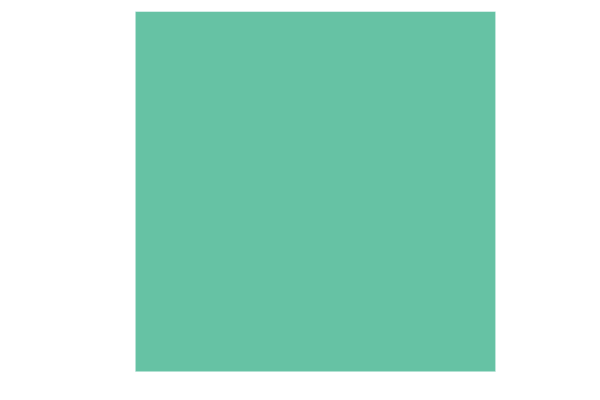

In [21]:
function plot_vorticity(sim)
    @inside sim.flow.σ[I] = WaterLily.curl(3,I,sim.flow.u)*sim.L/sim.U
    contourf(sim.flow.σ', 
        color=palette(:BuGn), clims=(-10,10),linewidth=0,
        aspect_ratio=:equal,legend=false,border=:none)
end

duration = 10.0 * T
step_size = T/10.

t = range(0, duration; step=step_size);
@gif for t_i in t
    sim_step!(swimmer, t_i)
    plot_vorticity(swimmer)
end

# Gabe's jellyfish - doesn't work :(

In [22]:
# using WaterLily
# using StaticArrays
# using GLMakie
# import CUDA

# function jelly(p=4;Re=5e2,mem=Array,U=1)
#     # Define simulation size, geometry dimensions, & viscosity
#     n = 2^p; R = 2n/3; h = 4n-2R; ν = U*R/Re

#     # Motion functions
#     ω = 2U/R
#     @fastmath @inline A(t) = 1 .- SA[1,1,0]*0.1*cos(ω*t)
#     @fastmath @inline B(t) = SA[0,0,1]*((cos(ω*t)-1)*R/4-h)
#     @fastmath @inline C(t) = SA[0,0,1]*sin(ω*t)*R/4

#     # Build jelly from a mapped sphere and plane
#     sphere = AutoBody((x,t)->abs(√sum(abs2,x)-R)-1, # sdf
#                       (x,t)->A(t).*x+B(t)+C(t))     # map
#     plane = AutoBody((x,t)->x[3]-h,(x,t)->x+C(t))
    
#     # TODO doesn't work for me
#     # body =  sphere-plane
#     body = sphere

#     # Return initialized simulation
#     # Simulation((n,n,4n),(0,0,-U),R;ν,body,mem,T=Float32)
#     Simulation((n,n,4n),[0,0,-U],R;ν,body,T=Float32)
#     # Simulation((n,4n),(0,-U),R;ν,body,mem,T=Float32)
# end

# function geom!(md,d,sim,t=WaterLily.time(sim))
#     a = sim.flow.σ
#     WaterLily.measure_sdf!(a,sim.body,t)
#     copyto!(d,a[inside(a)]) # copy to CPU
#     mirrorto!(md,d)         # mirror quadrant
# end

# function ω!(md,d,sim)
#     a,dt = sim.flow.σ,sim.L/sim.U
#     @inside a[I] = WaterLily.ω_mag(I,sim.flow.u)*dt
#     copyto!(d,a[inside(a)]) # copy to CPU
#     mirrorto!(md,d)         # mirror quadrant
# end

# function mirrorto!(a,b)
#     n = size(b,1)
#     a[reverse(1:n),reverse(1:n),:].=b
#     a[reverse(n+1:2n),1:n,:].=a[1:n,1:n,:]
#     a[:,reverse(n+1:2n),:].=a[:,1:n,:]
#     return a
# end


In [23]:
# begin
#     # Define geometry and motion on GPU
#     sim = jelly(mem=CUDA.CuArray);

# #     # Create CPU buffer arrays for geometry flow viz 
# #     a = sim.flow.σ
# #     d = similar(a,size(inside(a))) |> Array; # one quadrant
# #     md = similar(d,(2,2,1).*size(d))  # hold mirrored data

# #     # Set up geometry viz
# #     geom = geom!(md,d,sim) |> Observable;
# #     fig, _, _ = contour(geom, levels=[0], alpha=0.01)

# #     #Set up flow viz
# #     ω = ω!(md,d,sim) |> Observable;
# #     volume!(ω, algorithm=:mip, colormap=:algae, colorrange=(1,10))
# #     fig
# end


In [24]:

# # Loop in time
# # record(fig,"jelly.mp4",1:200) do frame
# foreach(1:10) do frame
#     @show frame
#     sim_step!(sim,sim_time(sim)+0.05);
#     geom[] = geom!(md,d,sim);
#     ω[] = ω!(md,d,sim);
# end

# Splines

In [25]:
function b_spline_basis(i, r, t, u)
    u_i = u[i+1]
    u_i1 = u[i+2]
    u_ir = u[i+r+1]
    u_i1r = u[i+r+2]

    if r == 0 
        if u_i <= t <= u_i1
            return 1
        else 
            return 0
        end
    else
        N = b_spline_basis
        left = 0
        if (u_ir-u_i) != 0
            left = (t-u_i)/(u_ir-u_i) * N(i,r-1,t,u)
        end

        right = 0
        if (u_i1r-u_i1) != 0
            right = (u_i1r-t)/(u_i1r-u_i1) * N(i+1,r-1,t,u)
        end
        return left + right 
    end
end

function b_spline(dBx,dBy, n, knot_vector; steps=200)
    m = length(dBx)-1
    if length(knot_vector) != m+1+n+1
        println("The knot vector has the wrong length it should have m+1+n+1 = ", m+1+n+1, " components.")
        println("But it has ", length(knot_vector), " components")
        return
    end
    plot(;size=(700,500), axisratio=:equal, legend=false)
    u_min = knot_vector[1]
    u_max = knot_vector[end]
    step_size = (u_max-u_min)/(steps-1)
   
    curve = zeros(steps,2)
    N = (i,r,t)->b_spline_basis(i,r,t,knot_vector)
    c = 1
    for t=u_min:step_size:u_max
        pos = zeros(2)
        for i=0:m
            if knot_vector[i+1] != knot_vector[i+1+n]
                pos = pos .+ [dBx[i+1],dBy[i+1]].*N(i,n,t)
            end
        end
        curve[c,:] .= pos
        c += 1
    end
    plot!(curve[:,1],curve[:,2])
    plot!(dBx,dBy, linetype=:scatter, color=:red)
    plot!(dBx,dBy, color=:red)
    for i in 0:length(dBx)-1
        annotate!(dBx[i+1]+0.2,dBy[i+1]+0.35, "d_"*string(i))
    end

    png("b_spline")
end

b_spline (generic function with 1 method)

In [26]:
dBx = [0.0,-1,5,7, 9,13]
dBy = [0.0, 3,5,4,-2, 1]
b_spline(dBx, dBy, 2, [0,0,0,1,2,3,4,4,4])

"b_spline.png"